# Twitter Follower Crawler - Basic Functionality w/ Performance Reporting

In [1]:
# User GET Endpoint Rate Limits: https://developer.twitter.com/en/docs/basics/rate-limits

"""
env:
    TWITTER_CONSUMER_KEY:
    TWITTER_CONSUMER_SECRET:
    TWITTER_ACCESS_TOKEN:
    TWITTER_ACCESS_TOKEN_SECRET:
    
get_user_interactions: 
    args:
        twitter_usernames - A list of usernames for the twitter username. (could use id)
    
    returns: 
        interactions_count - list of tuples in the format ("username", count)
""";

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import tweepy
import networkx as nx
import matplotlib.pyplot as plt
from decouple import config
import re
import pandas as pd
from collections import Counter
import csv
from pandas.io.json import json_normalize
#!pip install line_profiler
%load_ext line_profiler

# lprun guide: https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

## Initialize Tweepy

In [3]:
TWITTER_AUTH = tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))

TWITTER_AUTH.set_access_token(config('TWITTER_ACCESS_TOKEN'),config('TWITTER_ACCESS_TOKEN_SECRET'))

TWITTER = tweepy.API(TWITTER_AUTH)

## Determine current rate limit stats

In [4]:
# Check the limit before running the function, then check again after and compare. 
start_api_check = TWITTER.rate_limit_status()
limits_alpha = json_normalize(start_api_check)

## This function performs search of user's interactions. 

In [5]:
def get_first_user_interactions(search):
    twitter_user = TWITTER.get_user(search)
    tweets = twitter_user.timeline(
                count=200, # Tweepy limit. 
                exclude_replies=False,
                include_rts=True,
                tweet_mode='extended'
    )
    b = [ i.full_text for i in tweets ]
    b = " ".join(b)
    b = b.lower()
    b = b.replace(search, "")
    interactions = re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)
    interactions_count = Counter(interactions).most_common(20)
    return interactions_count


In [6]:
def get_first_user_connections(search):
    twitter_user = TWITTER.get_user(search)
    tweets = twitter_user.timeline(
                count=1000,
                exclude_replies=False,
                include_rts=True,
                tweet_mode='extended'
    )
    b = [ i.full_text for i in tweets ]
    b = " ".join(b)
    b = b.lower()
    b = b.replace(search, "")
    interactions = re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)
    interactions = " ".join(interactions)
    return interactions, search

## Define a User

In [7]:
user = "bwinterrose"

In [8]:
%time
test_peeps = get_first_user_interactions(user)
test_peeps

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs


[('lambdaschool', 34),
 ('austen', 22),
 ('kaggle', 15),
 ('superhuman', 9),
 ('tommycollison', 8),
 ('paulg', 5),
 ('mwseibel', 5),
 ('arachnocapital2', 4),
 ('rasbt', 4),
 ('jason', 4),
 ('cameronlewis35', 4),
 ('ivanahuckova', 4),
 ('gauravvohra1', 4),
 ('cowtung', 3),
 ('stephen_walter', 3),
 ('elonmusk', 3),
 ('kays310', 3),
 ('hackernews', 3),
 ('mattmiesnieks', 3),
 ('danielgross', 3)]

## Fetch user's interactions and user's interactions' interactions. 

In [9]:
def fetch_interactions(username):
    a = get_first_user_interactions(username)
    an_interactions_list = []
    an_index = []
    get_first_user_connections(username)
    for i in range(len(a)):
        interactions, search = get_first_user_connections(a[i][0])
        an_interactions_list.append(interactions)
        an_index.append(search)
    return an_interactions_list, an_index

# Call the function with lprun
%lprun -f fetch_interactions interactions_list, index = fetch_interactions(user)

"""
Timer unit: 1e-06 s

Total time: 22.9809 s
File: <ipython-input-9-75db5e64f454>
Function: fetch_interactions at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def fetch_interactions(username):
     2         1     934981.0 934981.0      4.1      a = get_first_user_interactions(username)
     3         1          2.0      2.0      0.0      an_interactions_list = []
     4         1          0.0      0.0      0.0      an_index = []
     5         1     949273.0 949273.0      4.1      get_first_user_connections(username)
     6        21         20.0      1.0      0.0      for i in range(len(a)):
     7        20   21096562.0 1054828.1     91.8          interactions, search = get_first_user_connections(a[i][0])
     8        20         64.0      3.2      0.0          an_interactions_list.append(interactions)
     9        20         17.0      0.8      0.0          an_index.append(search)
    10         1          1.0      1.0      0.0      return an_interactions_list, an_index
"""

'\nTimer unit: 1e-06 s\n\nTotal time: 14.6175 s\nFile: <ipython-input-232-069571b6a7cd>\nFunction: fetch_interactions at line 2\n\nLine #      Hits         Time  Per Hit   % Time  Line Contents\n==============================================================\n     2                                           def fetch_interactions(username):\n     3         1     948398.0 948398.0      6.5      a = get_first_user_interactions(username)\n     4         1          2.0      2.0      0.0      an_interactions_list = []\n     5         1          1.0      1.0      0.0      an_index = []\n     6         1     999599.0 999599.0      6.8      get_first_user_connections(username)\n     7        11         15.0      1.4      0.0      for i in range(len(a)):\n     8        10   12669430.0 1266943.0     86.7          interactions, search = get_first_user_connections(a[i][0])\n     9        10         32.0      3.2      0.0          an_interactions_list.append(interactions)\n    10        10          

In [10]:
%time
from sklearn.feature_extraction.text import CountVectorizer
corpus = interactions_list
vectorizer = CountVectorizer(min_df=2)
X = vectorizer.fit_transform(corpus)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [11]:
import pandas as pd
display_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index=index)

In [12]:
display_df

,ad_lc17,allturtlesco,amasad,amyshackles,anthonyjcamp,aoc,apatelthompson,apple,at_neuner,austen,...,twitch,tylercowen,tylerwillis,uber,utekkare,visakanv,webdevmason,wsj,ycombinator,zencachola
lambdaschool,1,1,0,1,1,0,0,0,1,61,...,1,1,1,1,0,0,0,0,0,0
austen,0,0,0,1,0,0,0,0,1,0,...,0,0,1,2,1,1,4,0,0,0
kaggle,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
superhuman,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
tommycollison,0,0,0,0,0,0,0,0,2,33,...,0,0,0,0,0,0,1,0,1,0
paulg,0,0,5,0,0,0,1,0,0,11,...,0,2,0,0,0,0,3,0,2,0
mwseibel,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,27,0
arachnocapital2,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,1,0,0,0,0
rasbt,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
jason,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


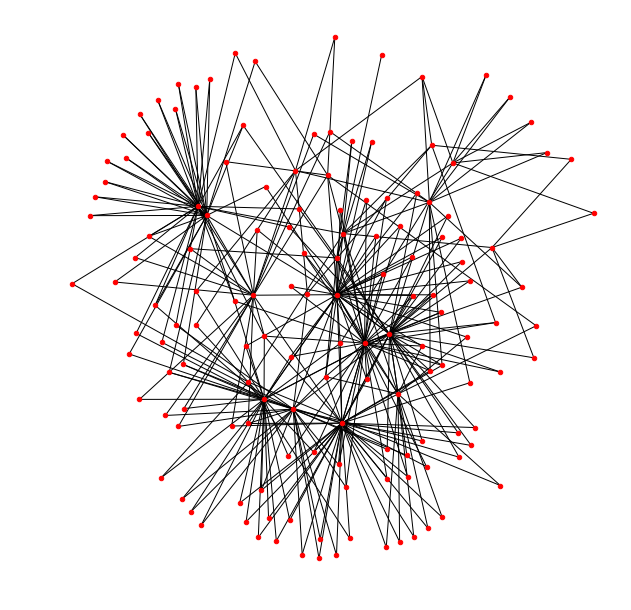

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
DG=nx.MultiGraph()

#loop through index, then the columns to find non-zero connections.
for i in display_df.index.values:
    for j in display_df.columns:
        if display_df[j].loc[i] >0 :
            DG.add_edge(j,i,display_df[j].loc[i] )
        else:
            pass
        
fig = plt.figure(figsize=(8,8))
nx.draw_kamada_kawai(DG,node_size=20)
plt.show()

## Examine API Impact of changes

In [14]:
end_api_check = TWITTER.rate_limit_status()
limits_beta = json_normalize(end_api_check).T
limits_beta.rename(columns = {0:'beta',}, inplace = True)

In [15]:
# Compare the change of ALL API ENDPOINTS between limits, alpha (before run), and beta (after run.)
limits_delta = limits_alpha.T.copy()
limits_delta['beta'] = limits_beta['beta']
limits_delta = limits_delta.reset_index(drop=False)
limits_delta.rename(columns = {0:'alpha', 'index':'api_endpoint'}, inplace = True)
limits_delta = limits_delta[['api_endpoint','alpha', 'beta']].assign(delta=limits_delta.alpha != limits_delta.beta)
limits_delta['type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 1, expand = True)[0]
limits_delta['sub_type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[1]
limits_delta['api_path'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[2].str.rsplit(pat = '.', n = 1, expand = True)[0]
limits_delta['method'] = limits_delta.api_path.str.rsplit(pat = '/', n = 1, expand = True)[1]
limits_delta['stat'] = limits_delta.api_endpoint.str.rsplit(pat = '.', n = 1, expand = True)[1]
limits_delta = limits_delta[['type', 'sub_type', 'api_path', 'method', 'stat', 'alpha', 'beta', 'delta']]

# Display filtered df. 
limits_delta[(limits_delta['stat'].str.contains("reset") == False) & (limits_delta['delta']==True)]



,type,sub_type,api_path,method,stat,alpha,beta,delta
50,resources,application,/application/rate_limit_status,rate_limit_status,remaining,176,175,True
365,resources,statuses,/statuses/user_timeline,user_timeline,remaining,837,814,True
431,resources,users,/users/show/:id,:id,remaining,837,814,True
